In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from functions import df_engineered, r2rmse_scores

import pickle
import time

In [2]:
feature_selection = ['ExterQual', 'BsmtQual', 'KitchenQual', 'OverallQual', 
                    'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'FullBath', 
                    'HouseAge', 'TotRmsAbvGrd', 'OverallCond',  'FlrSF1st', 'FlrSF2nd',
                    'Fireplaces', 'HasFireplace','LotFrontage', 'LotArea', 'MSSubClass', 'GoodGarageType', 
                    'BsmtUnfSF', 'Zone', 'Location', 'CulDSac', 'ExQual', 'RemodAge',
                    'Remod', 'ExBsmtQual', 'TwoStory', 'TotalSF', 'RoadRail', 'ExKitchen', 'CentralAir',
                    'TotalBath', 'Exterior1st_top']

In [3]:
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

data = df_engineered(df, Reg=False)

df shape: (2580, 80)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_selection], data['SalePrice'], test_size=0.30, random_state=42)

## Random Forest

#### Untuned model

In [5]:
rf_untuned = GradientBoostingRegressor(random_state=42)
rf_untuned.fit(X_train, y_train)

r2rmse_scores(rf_untuned, X_train, y_train)

--------------------------------------------------
5-fold Cross Validation Scoring
Mean R^2 score: 0.9306890161093972
Mean RMSE score: 18420.96957680719
--------------------------------------------------


In [6]:
yhat_train = rf_untuned.predict(X_train)
yhat_test = rf_untuned.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

12666.367773469008
20028.21033961294


#### Tuned Model

In [7]:
n_estimators = [int(x) for x in np.linspace(start = 90, stop = 100, num = 10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(3, 10, num = 7)]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [4, 8, 12, 15]
bootstrap = [True, False]


random_grid = [{'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap,
               'max_features':max_features,
               'min_samples_split': min_samples_split},
               {
               'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap,   
               'max_features':max_features,
               'min_samples_leaf': min_samples_leaf}]

pprint(random_grid)

[{'bootstrap': [True, False],
  'max_features': ['sqrt', 'log2'],
  'min_samples_split': [2, 5, 10, 15],
  'n_estimators': [90, 91, 92, 93, 94, 95, 96, 97, 98, 100]},
 {'bootstrap': [True, False],
  'max_features': ['sqrt', 'log2'],
  'min_samples_leaf': [4, 8, 12, 15],
  'n_estimators': [90, 91, 92, 93, 94, 95, 96, 97, 98, 100]}]


In [8]:
rf = RandomForestRegressor(random_state=42)

rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid, 
                               n_iter=100, 
                               cv=3, 
                               verbose=1, 
                               random_state=42, 
                               n_jobs = -1)

rf_random.fit(X_train, y_train)

r2rmse_scores(rf_random, X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
--------------------------------------------------
5-fold Cross Validation Scoring
Mean R^2 score: 0.921010714553929
Mean RMSE score: 19714.961120163996
--------------------------------------------------


In [9]:
yhat_train = rf_random.predict(X_train)
yhat_test = rf_random.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

198.11599228124976
20024.564093009973


In [10]:
#Get the parameters of the best forest
rf_random.best_params_

{'n_estimators': 91,
 'min_samples_split': 2,
 'max_features': 'sqrt',
 'bootstrap': False}

In [11]:
#Run a RF with the best parements and obtain the feature importance
rf_best = RandomForestRegressor(n_estimators=91, min_samples_split=2, \
                                max_features='sqrt', bootstrap=False, \
                                random_state=42)
rf_best.fit(X_train, y_train)

feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
importances = rf_best.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns).\
                               sort_values(ascending=False).to_frame().\
                                reset_index()
forest_importances.columns = ['feature', 'MDI']
forest_importances

,feature,MDI
0,TotalSF,0.148207
1,ExQual,0.105675
2,GrLivArea,0.092284
3,OverallQual,0.080966
4,Location,0.054374
5,ExterQual,0.050861
6,GarageArea,0.048532
7,HouseAge,0.046261
8,TotalBsmtSF,0.046063
9,TotalBath,0.043651


Text(0, 0.5, 'Mean decrease in impurity')

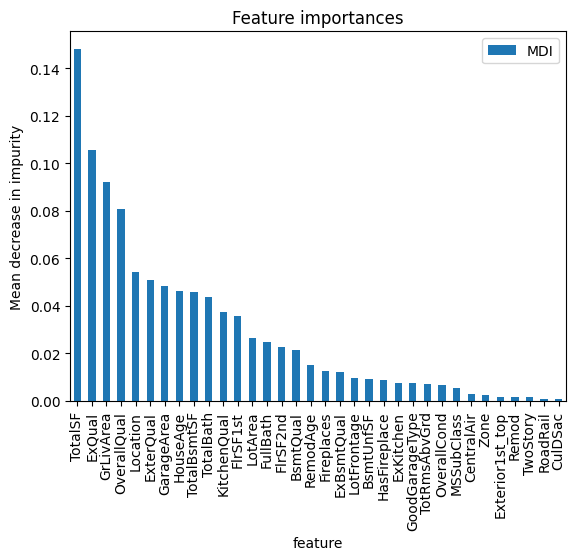

In [12]:
#bar plot feature by importance
fig = forest_importances.plot.bar(x='feature')
fig.set_title("Feature importances")
fig.set_ylabel("Mean decrease in impurity")


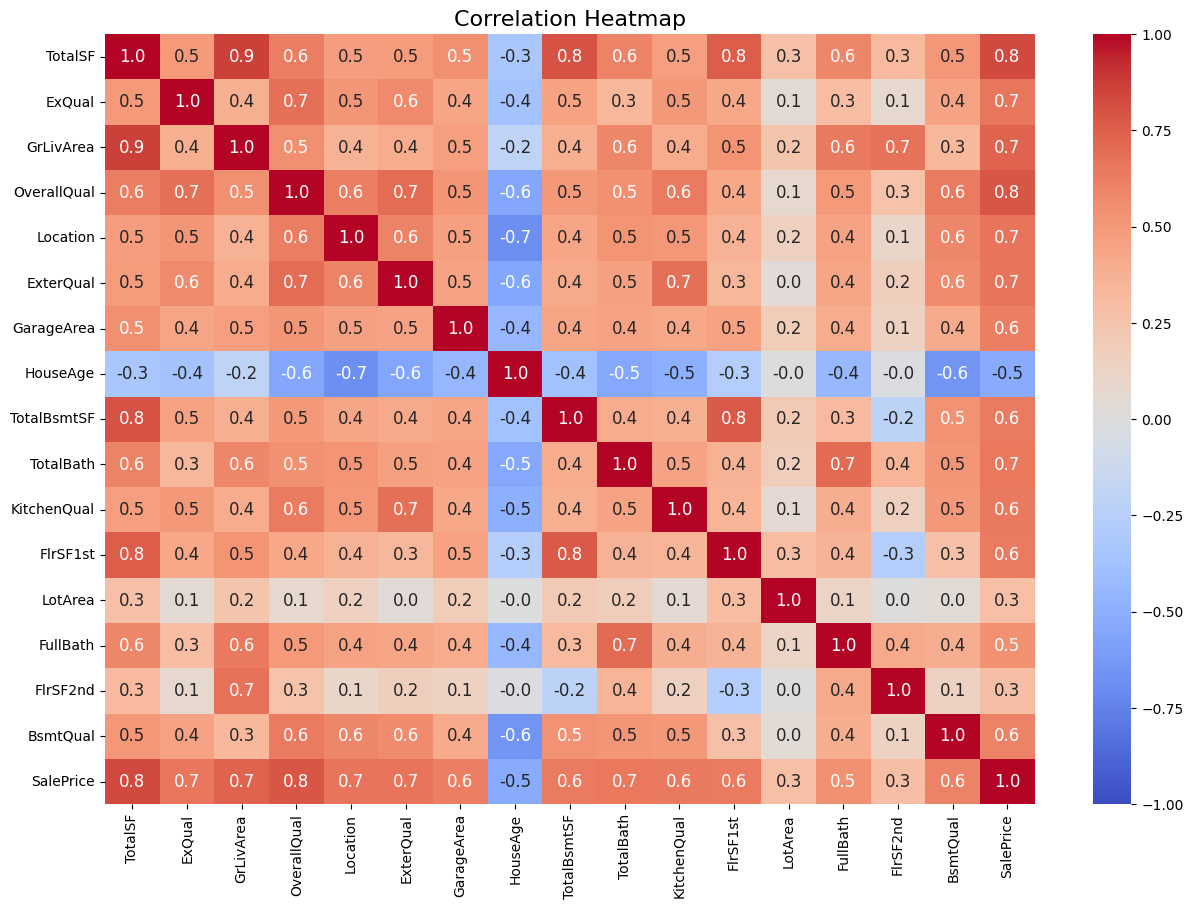

In [13]:
# Calculate the correlation matrix of the first 16 features
features_16 = forest_importances['feature'][0:16].tolist()
corr_mat = data[features_16 + ['SalePrice']].corr()

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot_kws={"size": 12}  # Set fontsize for annotations
            )

# Set the title
title = plt.title('Correlation Heatmap', fontsize=16)

# Display the plot
plt.show()


In [14]:
features_16 = [col for col in features_16 if col != 'Location']

In [15]:
#Scale features:
%store -r X_train 
%store -r X_test 
%store -r y_train 
%store -r y_test 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[features_16]), columns=X_train[features_16].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[features_16]), columns=X_test[features_16].columns)


no stored variable or alias X_train
no stored variable or alias X_test
no stored variable or alias y_train
no stored variable or alias y_test


In [16]:
#train LR based on rf feature selection

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

ols = LinearRegression()
ols.fit(X_train_scaled[features_16], y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.8496 0.8586 0.863  0.869  0.8916]
Mean shuffled cross validation score: 0.8664
RMSE Shuffled cross validation score: [25366.1104 27469.6627 25255.4251 26483.411  23441.3413]
RMSE Mean shuffled cross validation score: 25603.1901


In [17]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.8682
RMSE Test score: 26025.9213


#### Save best model

In [18]:
df.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FlrSF1st', 'FlrSF2nd',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Pav

In [19]:
#file_name = "rf_reg_{}.pkl".format(time.strftime("%Y%m%d-%H.%M.%S"))

# save
#pickle.dump(rf_random, open("saved_models/{}".format(file_name), "wb"))

# load
# file_name='rf_reg_20230719-14.40.17.pkl'
# rf_model_loaded = pickle.load(open("saved_models/{}".format(file_name), "rb"))

In [20]:
# yhat_train = rf_model_loaded.predict(X_train)
# yhat_test = rf_model_loaded.predict(X_test)

# train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
# test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

# print(train_rmse_non_log)
# print(test_rmse_non_log)

## XGBoost sklearn

#### Untuned model

In [21]:
xgb_untuned = GradientBoostingRegressor(random_state=42)
xgb_untuned.fit(X_train, y_train)

r2rmse_scores(xgb_untuned, X_train, y_train)

--------------------------------------------------
5-fold Cross Validation Scoring
Mean R^2 score: 0.9306890161093972
Mean RMSE score: 18420.96957680719
--------------------------------------------------


In [22]:
yhat_train = xgb_untuned.predict(X_train)
yhat_test = xgb_untuned.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

12666.367773469008
20028.21033961294


#### Tuned Model

In [23]:
n_estimators = [int(x) for x in np.linspace(start = 160, stop = 180, num = 10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 5, num = 5)]
min_samples_split = [4, 6, 8, 10]
min_samples_leaf = [2,3,4,5]
learning_rate = [0.01, 0.1, 0.2, 0.3]
alpha = [0.1, 0.2, 0.3, 0.4]
subsample = [0.6, 0.8, 0.9]

random_grid = [{'n_estimators': n_estimators,
               'max_features': max_features,
               'learning_rate':learning_rate,
               'alpha':alpha,
               'max_depth':max_depth,
               'subsample':subsample,
               'min_samples_split': min_samples_split},
               {
               'n_estimators': n_estimators,
               'max_features': max_features, 
               'learning_rate':learning_rate,
               'alpha':alpha,
               'max_depth':max_depth,
               'subsample':subsample,
               'min_samples_leaf': min_samples_leaf}]

pprint(random_grid)

[{'alpha': [0.1, 0.2, 0.3, 0.4],
  'learning_rate': [0.01, 0.1, 0.2, 0.3],
  'max_depth': [1, 2, 3, 4, 5],
  'max_features': ['sqrt', 'log2'],
  'min_samples_split': [4, 6, 8, 10],
  'n_estimators': [160, 162, 164, 166, 168, 171, 173, 175, 177, 180],
  'subsample': [0.6, 0.8, 0.9]},
 {'alpha': [0.1, 0.2, 0.3, 0.4],
  'learning_rate': [0.01, 0.1, 0.2, 0.3],
  'max_depth': [1, 2, 3, 4, 5],
  'max_features': ['sqrt', 'log2'],
  'min_samples_leaf': [2, 3, 4, 5],
  'n_estimators': [160, 162, 164, 166, 168, 171, 173, 175, 177, 180],
  'subsample': [0.6, 0.8, 0.9]}]


In [24]:
xgb = GradientBoostingRegressor(random_state=0)

xgb_random = RandomizedSearchCV(estimator=xgb, 
                               param_distributions=random_grid, 
                               n_iter=200, 
                               cv=3, 
                               verbose=1, 
                               random_state=42, 
                               n_jobs = -1)

xgb_random.fit(X_train, y_train)

r2rmse_scores(xgb_random, X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
--------------------------------------------------
5-fold Cross Validation Scoring
Mean R^2 score: 0.9331505720543978
Mean RMSE score: 18093.853795902378
--------------------------------------------------


In [25]:
yhat_train = xgb_random.predict(X_train)
yhat_test = xgb_random.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

11966.839297374434
18209.11168563627


#### Save best model

In [26]:
#file_name = "xgb_reg_{}.pkl".format(time.strftime("%Y%m%d-%H.%M.%S"))

# save
#pickle.dump(xgb_random, open('saved_models/{}'.format(file_name), "wb"))

# load
# file_name='xgb_reg_20230719-13.12.55.pkl'
# xgb_model_loaded = pickle.load(open('saved_models/{}'.format(file_name), "rb"))

In [27]:
# yhat_train = xgb_model_loaded.predict(X_train)
# yhat_test = xgb_model_loaded.predict(X_test)

# train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
# test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

# print(train_rmse_non_log)
# print(test_rmse_non_log)

## LightGBM

#### Untuned model

In [28]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [29]:
yhat_train = lgbm.predict(X_train)
yhat_test = lgbm.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

9024.91978810812
21787.229150430783


#### Tuned Model

In [30]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 190, num = 10)]
max_depth = [int(x) for x in np.linspace(2, 5, num = 3)]
learning_rate = [0.08, 0.1, 0.2, 0.3]
alpha = [0.1, 0.2, 0.3, 0.4]
subsample = [0.6, 0.8, 0.9]
min_child_samples = [3,4, 5, 6,7]
colsample_bytree = [0.7, 0.8, 0.9]

random_grid = [{'n_estimators': n_estimators,
               'learning_rate':learning_rate,
               'alpha':alpha,
               'max_depth':max_depth,
               'subsample':subsample,
               'min_child_samples':min_child_samples,
               'colsample_bytree':colsample_bytree}]

random_grid

[{'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150, 170, 190],
  'learning_rate': [0.08, 0.1, 0.2, 0.3],
  'alpha': [0.1, 0.2, 0.3, 0.4],
  'max_depth': [2, 3, 5],
  'subsample': [0.6, 0.8, 0.9],
  'min_child_samples': [3, 4, 5, 6, 7],
  'colsample_bytree': [0.7, 0.8, 0.9]}]

In [31]:
lgbm = lgb.LGBMRegressor(objective='regression', 
                                random_state=42)

lgbm_random = RandomizedSearchCV(estimator=lgbm, 
                      param_distributions=random_grid,
                      n_iter=300, 
                      cv=5, 
                      verbose=1, 
                      random_state=42, 
                      n_jobs = -1,
                      scoring='neg_root_mean_squared_error')

lgbm_random.fit(X_train, y_train)

r2rmse_scores(lgbm_random, X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
--------------------------------------------------
5-fold Cross Validation Scoring
Mean R^2 score: 0.9333214263922288
Mean RMSE score: 18065.01453916439
--------------------------------------------------


In [32]:
yhat_train = lgbm_random.predict(X_train)
yhat_test = lgbm_random.predict(X_test)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

10955.681058562164
18457.312421091672


In [33]:
lgbm_random.best_params_

{'subsample': 0.6,
 'n_estimators': 190,
 'min_child_samples': 4,
 'max_depth': 3,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8,
 'alpha': 0.1}

#### Save best model

In [34]:
#file_name = "lgbm_reg_{}.pkl".format(time.strftime("%Y%m%d-%H.%M.%S"))

# save
#pickle.dump(lgbm_random, open('saved_models/{}'.format(file_name), "wb"))

# load
# file_name='lgbm_reg_20230719-15.03.27.pkl'
# lgbm_model_loaded = pickle.load(open('saved_models/{}'.format(file_name), "rb"))

In [35]:
# yhat_train = lgbm_model_loaded.predict(X_train)
# yhat_test = lgbm_model_loaded.predict(X_test)

# train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
# test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

# print(train_rmse_non_log)
# print(test_rmse_non_log)